<a href="https://colab.research.google.com/github/flyingtaho/blueberryTaho/blob/main/MBAlejo_MLEPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**blueberry-taho**

> This notebook contain the end-to-end solution pipeline to the SMLE coding challenge of GCash as of October 28, 2025.

> This notebook does the following:


*   Read and explore CSV datasets.
*   Implementation of logistic regression model with weights are defined.
*   Searching of valid data sample
*   Sends sample as a JSON payload to endpoint
*   Display response in a webUI (colab via flask n ngrok)
*   Saves artifacts.

> Marwin B. Alejo | [Github](https://github.com/flyingtaho/blueberryTaho/tree/main)

>



In [1]:
# Install dependencies. Only execute this cell once.
!pip install -q pyngrok flask torch requests pandas

In [2]:
# Necessary libraries and imports
import os
import json
import math
import requests
import pandas as pd
import torch
import torch.nn.functional as F
from google.colab import drive
from typing import Dict, Any
import os
from pyngrok import ngrok
drive.mount('/content/drive')
ngrok.set_auth_token("34gpSnj6LJTjkiSkCC61hCUlOhl_4UJoZDbXAfkaHX6mKK9NQ")


# Sigmoid/logit helpers
def sigmoid(x):
    return 1.0 / (1.0 + math.exp(-x))

def logit(p):
    return math.log(p / (1 - p))

TARGET_PROB = 0.999
Z_REQUIRED = logit(TARGET_PROB)  # ≈ 6.90675478
print("z required for p >= 0.999:", Z_REQUIRED)

Mounted at /content/drive
z required for p >= 0.999: 6.906754778648553


In [3]:
# Datapaths; modify the paths depending on the env
app_csv = "/content/drive/MyDrive/blueberi/dummy_application_data.csv"
travel_csv = "/content/drive/MyDrive/blueberi/dummy_travel_data.csv"

# Load the datasets to check if they exist from the paths
app_df = pd.read_csv(app_csv)
travel_df = pd.read_csv(travel_csv)

print("\nApplication data preview:")
display(app_df.head())

print("\nTravel data preview:")
display(travel_df.head())


Application data preview:


,id,age,residential_status,income,education,location,is_employed,credit_score,owns_car,target_variable
0,0,189,Living with family/friends,260325,Postgraduate,International,True,227,False,False
1,1,252,Living with family/friends,268310,College,Domestic,False,105,False,False
2,2,257,Renter,133290,Postgraduate,International,True,119,True,False
3,3,290,Renter,817061,Postgraduate,International,False,126,False,False
4,4,275,Renter,426743,College,International,True,363,True,False



Travel data preview:


,id,destination,miles,flight_date
0,0,Domestic,3545,2023-12-07
1,0,International,6891,2023-03-15
2,0,International,3822,2023-09-06
3,0,International,7276,2023-06-09
4,0,International,4883,2023-12-19


In [4]:
# Numeric ranges
num_cols = ["age", "income", "credit_score"]
for c in num_cols:
    print(f"{c}: min={app_df[c].min()}, max={app_df[c].max()}, mean={app_df[c].mean():.2f}")

# travel_frequency: compute from travel_df: count distinct trips per user id during 2023
travel_freq = travel_df.groupby("id").size().rename("travel_frequency").reset_index()
print("\nTravel frequency stats (per user):")
display(travel_freq["travel_frequency"].describe())

# Show residential_status and education unique values
print("\nResidential status unique values:", app_df["residential_status"].unique())
print("Education unique values:", app_df["education"].unique())
print("Location unique values:", app_df["location"].unique())

# For 'owns_car' and 'is_employed' show distribution
print("\nowns_car value counts:\n", app_df["owns_car"].value_counts(dropna=False))
print("\nis_employed value counts:\n", app_df["is_employed"].value_counts(dropna=False))

age: min=150, max=299, mean=224.89
income: min=50000, max=999980, mean=525100.43
credit_score: min=100, max=449, mean=274.52

Travel frequency stats (per user):


,travel_frequency
count,100000.000000
mean,29.015720
std,7.866384
min,10.000000
25%,23.000000
50%,29.000000
75%,34.000000
max,76.000000



Residential status unique values: ['Living with family/friends' 'Renter' 'Other' 'Owner']
Education unique values: ['Postgraduate' 'College' 'High School']
Location unique values: ['International' 'Domestic']

owns_car value counts:
 owns_car
False    50123
True     49877
Name: count, dtype: int64

is_employed value counts:
 is_employed
True     50383
False    49617
Name: count, dtype: int64


In [5]:
# Declared coefficients as provided in the email instructions
coeffs = {
    "age": 0.0156,
    "income": 2.2177,
    "credit_score": 2.6590,
    "travel_frequency": 1.1344,
    "owns_car": 0.0341,
    "is_employed": -0.0703,

    # residential_status as one-hot components
    "residential_Living with family/friends": 0.0201,
    "residential_Owner": 0.0203,
    "residential_Renter": 0.0247,
    "residential_Other": -0.0629,

    # Location: only International coefficient specified; assume baseline 0 for others
    "location_International": -0.0333,

    # Education one-hot
    "education_College": 1.9276,
    "education_High School": -3.8321,
    "education_Postgraduate": 1.9067,
}

# Assuming 0 intercept unless provided.
INTERCEPT = 0.0


In [6]:
# Numerical ranges from the dataset
age_min, age_max = int(app_df["age"].min()), int(app_df["age"].max())
income_min, income_max = int(app_df["income"].min()), int(app_df["income"].max())
credit_min, credit_max = int(app_df["credit_score"].min()), int(app_df["credit_score"].max())

# Observable travel frequency
tf_min, tf_max = int(travel_freq["travel_frequency"].min()), int(travel_freq["travel_frequency"].max())
print("Observed ranges:")
print(f"age: {age_min} - {age_max}")
print(f"income: {income_min} - {income_max}")
print(f"credit_score: {credit_min} - {credit_max}")
print(f"travel_frequency: {tf_min} - {tf_max}")

# Strategy: maximize positive contributors (income, credit_score, travel_frequency) within observed ranges.
# Choose education = 'College' or 'Postgraduate' (both positive). Pick the highest numeric values but still within observed ranges.
candidate = {
    "age": age_max,  # older if coefficient is positive
    "residential_status": "Renter",  # small positive coef (0.0247)
    "income": income_max,
    "education": "College",  # 1.9276 (slightly better than Postgraduate? both positive; pick College)
    "location": "Domestic",  # avoid 'International' (which has -0.0333). Use a location value present in dataset that's not 'International' if possible
    "is_employed": False,  # coefficient negative for employed, so False helps
    "credit_score": credit_max,
    "owns_car": True,
    "travel_frequency": tf_max
}

# If 'Domestic' isn't in location categories, pick the first non-'International' location from observed
locs = list(app_df["location"].unique())
if "International" in locs and len(locs) > 1:
    # pick the first not International
    for L in locs:
        if L != "International":
            candidate["location"] = L
            break
elif "International" in locs and len(locs) == 1:
    # only international present — we'll still use it but it's slightly negative
    candidate["location"] = "International"

print("\nCandidate sample chosen (within observed ranges):")
print(candidate)


Observed ranges:
age: 150 - 299
income: 50000 - 999980
credit_score: 100 - 449
travel_frequency: 10 - 76

Candidate sample chosen (within observed ranges):
{'age': 299, 'residential_status': 'Renter', 'income': 999980, 'education': 'College', 'location': 'Domestic', 'is_employed': False, 'credit_score': 449, 'owns_car': True, 'travel_frequency': 76}


In [7]:
def compute_logit_and_prob(sample: Dict[str, Any]):
    z = INTERCEPT

    # Numeric features
    z += coeffs["age"] * float(sample["age"])
    z += coeffs["income"] * float(sample["income"])
    z += coeffs["credit_score"] * float(sample["credit_score"])
    z += coeffs["travel_frequency"] * float(sample["travel_frequency"])

    # Boolean features
    z += coeffs["owns_car"] * (1.0 if sample["owns_car"] else 0.0)
    z += coeffs["is_employed"] * (1.0 if sample["is_employed"] else 0.0)

    # Residential status one-hot
    rs_key = "residential_" + sample["residential_status"]
    z += coeffs.get(rs_key, 0.0)

    # Location
    if sample["location"] == "International":
        z += coeffs["location_International"]

    # Education
    edu_key = "education_" + sample["education"]
    z += coeffs.get(edu_key, 0.0)
    p = sigmoid(z)
    return z, p

z, p = compute_logit_and_prob(candidate)
print(f"Computed z = {z:.6f}, probability = {p:.12f}")

if p < TARGET_PROB:
    print("\nProbability below target. Options:")
    print("- increase numeric values within observed ranges (income, credit_score, travel_frequency)")
    print("- choose the education with the larger positive coefficient (College or Postgraduate)")
else:
    print("\nProbability meets or exceeds target. You can now POST this sample to the endpoint.")


Computed z = 2218942.402200, probability = 1.000000000000

Probability meets or exceeds target. You can now POST this sample to the endpoint.


In [8]:
# If initial candidate doesn't reach z threshold, try to greedily uplift features in order of coefficient impact
def uplift_to_target(sample: Dict[str, Any]):
    z, p = compute_logit_and_prob(sample)
    if z >= Z_REQUIRED:
        return sample, z, p

    # feature order by coefficient magnitude (descending)
    # use tuples (feature_name, coefficient, max_value)
    features = [
        ("income", coeffs["income"], income_max),
        ("credit_score", coeffs["credit_score"], credit_max),
        ("travel_frequency", coeffs["travel_frequency"], tf_max),
        ("age", coeffs["age"], age_max),
    ]
    # Attempt to sequentially set each feature to its max (it's already at max in many cases) and re-evaluate
    s = sample.copy()
    for feat, coef, maxv in features:
        s[feat] = maxv
        z, p = compute_logit_and_prob(s)
        if z >= Z_REQUIRED:
            return s, z, p
    # If still insufficient, attempt to flip is_employed to False (already done) and ensure education is best positive
    s["education"] = "College"  # choose College or Postgraduate
    z, p = compute_logit_and_prob(s)
    if z >= Z_REQUIRED:
        return s, z, p

    # No further improvement within simple strategy -> return current best
    return s, z, p

best_sample, best_z, best_p = uplift_to_target(candidate)
print("Best candidate after uplift:", best_sample)
print(f"z = {best_z:.6f}, p = {best_p:.12f}")

if best_p < TARGET_PROB:
    print("\nCould not reach target probability using simple greedy uplift within observed ranges.")
    print("If that happens, consider verifying the dataset ranges or whether the model expects different encoding (intercept, scaled features).")
else:
    print("\nReached target. Proceed to POST.")


Best candidate after uplift: {'age': 299, 'residential_status': 'Renter', 'income': 999980, 'education': 'College', 'location': 'Domestic', 'is_employed': False, 'credit_score': 449, 'owns_car': True, 'travel_frequency': 76}
z = 2218942.402200, p = 1.000000000000

Reached target. Proceed to POST.


**CLI-based Solution**

In [9]:
ENDPOINT = "https://mle-test-app-55hmh2trlq-as.a.run.app/predict"

# Build JSON payload with keys exactly as required by the endpoint
payload = {
    "age": int(best_sample["age"]),
    "residential_status": best_sample["residential_status"],
    "income": int(best_sample["income"]),
    "education": best_sample["education"],
    "location": best_sample["location"],
    "is_employed": bool(best_sample["is_employed"]),
    "credit_score": int(best_sample["credit_score"]),
    "owns_car": bool(best_sample["owns_car"]),
    "travel_frequency": int(best_sample["travel_frequency"]),
}

print("Payload to be sent:")
print(json.dumps(payload, indent=2))

# Send POST request
resp = requests.post(ENDPOINT, json=payload)
print("\nHTTP status code:", resp.status_code)
try:
    print("Response JSON:")
    print(resp.json())
except Exception:
    print("Raw response text:")
    print(resp.text)


Payload to be sent:
{
  "age": 299,
  "residential_status": "Renter",
  "income": 999980,
  "education": "College",
  "location": "Domestic",
  "is_employed": false,
  "credit_score": 449,
  "owns_car": true,
  "travel_frequency": 76
}

HTTP status code: 200
Response JSON:
{'password': ":TUZ8DuC?<%#;)'vE;,F^6x\\3YT&lE_G"}


# **UI-based Solution**

In [10]:
# Beautiful Flask + ngrok
from flask import Flask, render_template_string, request
from pyngrok import ngrok, conf
import json, requests
from threading import Thread

conf.get_default().region = "ap"
app = Flask(__name__)

# HTML template
TEMPLATE = """
<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8">
<meta name="viewport" content="width=device-width, initial-scale=1.0">
<title>blueberi-taho</title>
<style>
  body {
    background: linear-gradient(180deg, #0072ff, #00c6ff);
    font-family: 'Poppins', Arial, sans-serif;
    color: white;
    display: flex;
    justify-content: center;
    align-items: center;
    height: 100vh;
    margin: 0;
  }
  .card {
    background: white;
    color: #003f7f;
    border-radius: 20px;
    box-shadow: 0 8px 20px rgba(0,0,0,0.15);
    padding: 30px 40px;
    width: 90%;
    max-width: 600px;
    text-align: center;
  }
  h2 {
    color: #0072ff;
    margin-bottom: 20px;
  }
  pre {
    background: #f7f9fc;
    color: #002b5c;
    text-align: left;
    padding: 15px;
    border-radius: 10px;
    overflow-x: auto;
    font-size: 13px;
  }
  button {
    background: linear-gradient(90deg, #0072ff, #00c6ff);
    border: none;
    color: white;
    padding: 12px 25px;
    border-radius: 8px;
    font-size: 16px;
    cursor: pointer;
    transition: 0.3s ease;
  }
  button:hover {
    background: linear-gradient(90deg, #0062dd, #00aaff);
    transform: translateY(-2px);
  }
  .footer {
    font-size: 12px;
    margin-top: 20px;
    color: #666;
  }
</style>
</head>
<body>
  <div class="card">
    <h2>MLE Predictor and Password Generator</h2>
    <p>Click the button below to send your payload to the endpoint.</p>
    <form action="/submit" method="post">
      <button type="submit">Submit to Endpoint</button>
    </form>
    <h3>Payload</h3>
    <pre>{{ payload }}</pre>
    {% if result %}
    <h3>Returned Password</h3>
    <pre>{{ result }}</pre>
    {% endif %}
    <div class="footer">Marwin Alejo</div>
  </div>
</body>
</html>
"""

# Flask routes
@app.route("/", methods=["GET"])
def index():
    return render_template_string(TEMPLATE, payload=json.dumps(payload, indent=2), result="")

@app.route("/submit", methods=["POST"])
def submit():
    r = requests.post(ENDPOINT, json=payload)
    try:
        res_text = json.dumps(r.json(), indent=2)
    except Exception:
        res_text = r.text
    return render_template_string(TEMPLATE, payload=json.dumps(payload, indent=2), result=res_text)

# Ngrok
port = 5000
public_url = ngrok.connect(port).public_url
print("🔗 ngrok tunnel active:", public_url)
print("🌍 Open this URL in your browser to use the GCash-blue web app.")

# Execute Flask app
def run():
    app.run(port=port, debug=False, use_reloader=False)

Thread(target=run).start()


🔗 ngrok tunnel active: https://strangledly-unconventional-annalee.ngrok-free.dev
🌍 Open this URL in your browser to use the GCash-blue web app.


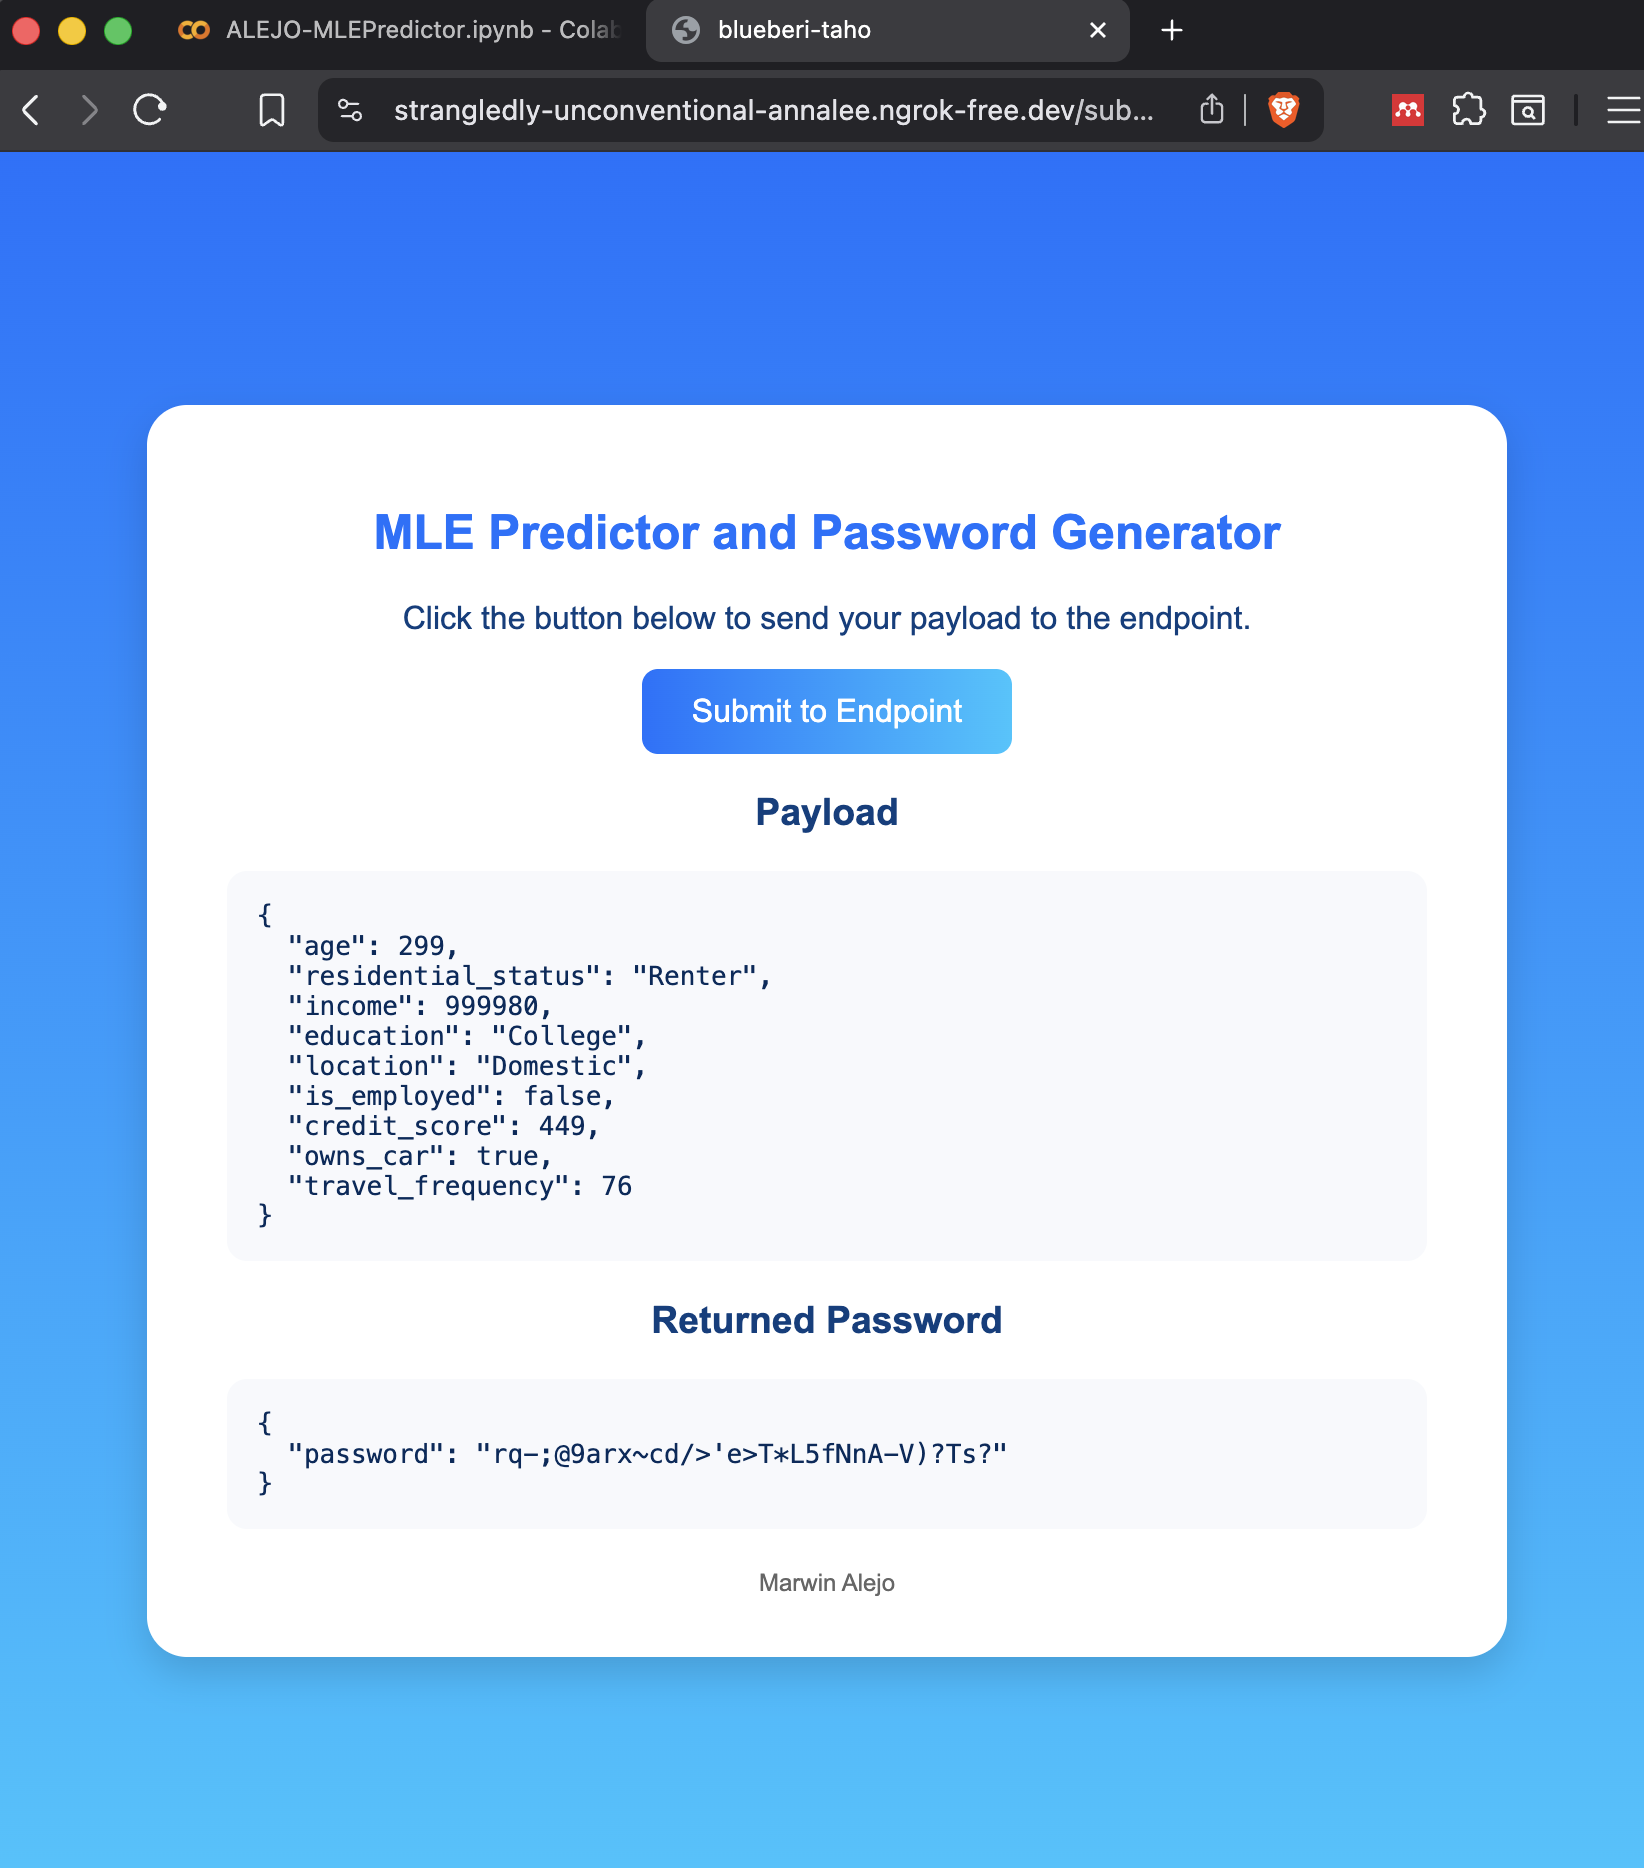